### pip install & import

In [198]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflowjs as tfjs
import pandas as pd
#import pandas_profiling
import datetime

In [199]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


import kerastuner as kt

In [200]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

# from xgboost import XGBRFRegressor
from sklearn.model_selection import cross_validate

### 최종데이터 불러오기

In [201]:
movie_final = pd.read_csv('../3_merge_top300/movie_final.csv',encoding='utf-8')

## 원핫인코딩 

In [6]:
# 원핫인코딩

# movie_labels = pd.get_dummies(movie_final,columns = ['국적','장르','등급','계절'])

In [7]:
# 독립 변수와 종속 변수 나눔

# 독립 = movie_DL[['감독_흥행', '배급사_흥행', '국적_기타', '국적_독일', '국적_미국',
#        '국적_영국', '국적_일본', '국적_중국', '국적_프랑스', '국적_한국', '장르_SF', '장르_가족', '장르_공연',
#        '장르_공포(호러)', '장르_기타', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_뮤지컬',
#        '장르_미스터리', '장르_범죄', '장르_사극', '장르_서부극(웨스턴)', '장르_성인물(에로)', '장르_스릴러',
#        '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_전쟁', '장르_코미디', '장르_판타지',
#        '등급_12세관람가', '등급_15세관람가', '등급_전체관람가', '등급_청소년관람불가', '계절_가을', '계절_겨울',
#        '계절_봄', '계절_여름']] 
# 종속 = movie_DL[['전국 관객수']] 

## 라벨링

In [202]:
from sklearn.preprocessing import LabelEncoder

le_form = LabelEncoder()
le_nation = LabelEncoder()
le_genre = LabelEncoder()
le_rating = LabelEncoder()
le_class = LabelEncoder()
le_season = LabelEncoder()

movie_labels = movie_final.copy()
movie_labels['영화형태'] = le_form.fit_transform(movie_final['영화형태'])
movie_labels['국적'] = le_nation.fit_transform(movie_final['국적'])
movie_labels['장르'] = le_genre.fit_transform(movie_final['장르'])
movie_labels['등급'] = le_rating.fit_transform(movie_final['등급'])
movie_labels['영화구분'] = le_class.fit_transform(movie_final['영화구분'])
movie_labels['계절'] = le_season.fit_transform(movie_final['계절'])
movie_labels.drop(['Unnamed: 0'],axis=1,inplace=True)
movie_labels.head(3)


,순번,영화명,감독,배급사,개봉일,영화형태,국적,전국 스크린수,전국 매출액,전국 관객수,...,연도,월,계절,총 관객수,코로나,출연,평점,감독_흥행,배급사_흥행,주연배우_흥행
0,2575,미니특공대X,이영준,삼지애니메이션,2018-03-22,2,7,458,744858200,99952,...,2018,3,2,216385269,0,"['엄상현', '전태열', '이소영', '신용우']",7.55,0,0,0
1,2578,알파독,닉 카사베츠,싸이더스,2009-01-29,2,2,161,648950794,99692,...,2009,1,1,155398654,0,"['에밀 허쉬', '저스틴 팀버레이크', '벤 포스터', '안톤 옐친', '아만다 ...",6.06,0,6,7
2,2583,엘비스,바즈 루어만,워너브러더스 코리아,2022-07-13,2,2,665,1070700628,98706,...,2022,7,3,112805094,1,"['오스틴 버틀러', '톰 행크스']",8.83,0,10,5


### 데이터분배
1) movie_labels_etc : train과 val data   
2) movie_labels_2023 : test data

In [203]:
movie_labels_2023 = movie_labels[movie_labels['연도']==2023]
movie_labels_etc = movie_labels[movie_labels['연도']!=2023]

### 변수 정리   
1. 사용하지 않는 컬럼 제거
2. 독립변수와 종속변수 설정

In [204]:
# 사용하지 않는 컬럼 제거

not_used = ['영화명', '감독', '배급사', '영화형태', '개봉일', '영화구분', '월']

movie_DL = movie_labels_etc.drop(not_used, axis=1) # 2003~2022 데이터 main
movie_DL2 = movie_labels_2023.drop(not_used, axis=1)# 2023년 test


In [12]:
# 국적 => 국내 vs 해외
# 관객비율.. 2023년 데이터 총 관객수 몰라....
# 비율 말고 총 관객수를 쓰자
# 총관객수 defqult를 2022년으로 해서 2023년 총관객수 채우면 어때?

In [205]:
종속 = movie_DL[['전국 관객수']].copy()
종속['전국 관객수'] = 종속['전국 관객수'] / 1000 

종속_2023 = movie_DL2[['전국 관객수']].copy()
종속_2023['전국 관객수'] = 종속_2023['전국 관객수'] / 1000 


독립 = movie_DL[['장르', '등급', '감독_흥행',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수','연도','코로나']].copy()

독립_2023 = movie_DL2[['장르', '등급', '감독_흥행',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수','연도','코로나']].copy()

## train, test 데이터 나누기

In [206]:
# train, test 데이터 나눔

from sklearn.model_selection import train_test_split
train_input, test_input, train_target,test_target = train_test_split(독립,종속,test_size=0.25,random_state=42)

In [134]:
train_input.columns

Index(['장르', '등급', '감독_흥행', '총 관객수', '배급사_흥행', '주연배우_흥행', '계절', '전국 스크린수',
       '연도', '코로나'],
      dtype='object')

## 스케일링... 
...어디서 할까...<br>
라벨링 때문에 바로 스케일링을 따로 해줘야함 (전국스크린수, 총 관객수)

In [135]:
# 값 스케일링

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [ ]:
train_input

In [188]:
from sklearn.preprocessing import RobustScaler

# 객체생성
robust_scaler = RobustScaler()

# *** 만약 특정 열의 스케일링을 하고 싶은 경우 ***
A_n = robust_scaler.fit_transform(train_input['전국 스크린수'].values.reshape(-1,1))
train_input.insert(0, '전국 스크린수_1', A_n)
train_input.drop(['전국 스크린수'], axis=1, inplace=True)

# A_n1 = robust_scaler.fit_transform(train_input['총 관객수'].values.reshape(-1,1))
# train_input.insert(0, '총 관객수_1', A_n1)
# train_input.drop(['총 관객수'], axis=1, inplace=True)

In [189]:
A_n = robust_scaler.fit_transform(독립_2023['전국 스크린수'].values.reshape(-1,1))
독립_2023.insert(0, '전국 스크린수_1', A_n)
독립_2023.drop(['전국 스크린수'], axis=1, inplace=True)

# A_n1 = robust_scaler.fit_transform(독립_2023['총 관객수'].values.reshape(-1,1))
# 독립_2023.insert(0, '총 관객수_1', A_n1)
# 독립_2023.drop(['총 관객수'], axis=1, inplace=True)

In [ ]:
train_input

### tunner를 이용한 하이퍼파라미터 찾기

해야할일 : 우리 모델에 맞는 뉴런 수, 활성화 함수 , learning rate, batch_size를 찾아야한다.

In [ ]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    # units_1 => 뉴런 갯수를 조정하는 부분
    # dropout_1 => dropout 부분을 조정하는 부분
    hp_units1 = hp.Int('units_1', min_value = 16, max_value = 180)
    hp_units2 = hp.Int('units_2', min_value = 16, max_value = 180)
    hp_units4 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)
    hp_units5 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05)


    # 현재 레이어 층은
    # 입력층 > 히든층 > 출력층으로 되어있다.
    model = keras.Sequential()
    
    #입력층
    model.add(layers.Dense(hp_units1, activation='swish', input_shape=[9]))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp_units4))
    
    # 히든층
    model.add(layers.Dense(hp_units2, activation='swish'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp_units5))
    
    # 출력층
    model.add(layers.Dense(1, activation='swish'))

    # 1. learning rate 범위 설정
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3)
    # 2. 옵티마이저 설정
    # Choice를 통해 값을 선택에서 받음
    # hp.int을 쓰면 정수값, hp.Float를 쓰면 소수값, hp.Choice를 쓰면 선택해서
    # Adam
    Adam = optimizers.Adam(learning_rate=hp_learning_rate,beta_1=hp.Choice('beta_1',[.9,.8,.7,.6,.5]),beta_2=hp.Choice('beta_2',[.99,.88,.77,.66,.55]))
    # SGD 
    SGD = optimizers.SGD(learning_rate=hp_learning_rate,momentum=hp.Choice('momentum',[.9,.8,.7,.6,.5]))
    # 나머지 추가해야함

    model.compile(optimizer=SGD, loss='mae')
    return model
  
  # 배치사이즈 설정
  def fit(self, hp, model, *args, **kwargs):
      return model.fit(
          *args,
          batch_size=hp.Int('batch_size', min_value = 16, max_value = 256, step = 16),
          **kwargs,
      )

In [ ]:
tuner = kt.Hyperband(MyHyperModel(),
                    objective = 'loss',
                    max_epochs = 100,
                    executions_per_trial = 3,
                    overwrite = True,
                    factor = 3)

tuner.search(train_input,train_target, epochs = 100, validation_split = 0.1)

In [ ]:
# 최적 하이퍼파라미터를 가져옵니다.
best_hps = tuner.get_best_hyperparameters()[0]



# 최적 하이퍼파라미터를 출력합니다.
print(f"""
units_1 : {best_hps.get('units_1')}
units_2 : {best_hps.get('units_2')}
dropout_1 : {best_hps.get('dropout_1')}
dropout_2 : {best_hps.get('dropout_2')}
learning_rate : {best_hps.get('learning_rate')}
batch_size : {best_hps.get('batch_size')}
momentum : {best_hps.get('momentum')}
""")

In [ ]:
# 배치 크기는 따로 저장했다가 fit 메소드에서 적용합니다.
batch_size = best_hps.get('batch_size')



# 최적값으로 모델을 생성합니다.
model = tuner.hypermodel.build(best_hps)


In [ ]:
model.summary()

In [ ]:
# 훈련

model.fit(train_scaled,train_target,batch_size=batch_size,epochs=100,validation_data=(test_scaled,test_target))

# 딥러닝 


In [251]:
# 딥러닝 층 여기가 중요

X = tf.keras.layers.Input(shape=[9])

H = tf.keras.layers.Dense(128)(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.swish)(H)

H = tf.keras.layers.Dense(64)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.swish)(H)

Y = tf.keras.layers.Dense(1)(H)
model = tf.keras.models.Model(X,Y)
sgd = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.99)
# sgd = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9)
model.compile(optimizer=sgd,loss='mse')

In [254]:
# 훈련

history = model.fit(train_input,train_target,batch_size=128,epochs=50,validation_data=(test_input,test_target))

Epoch 1/50
9/9 [==============================] - 0s 8ms/step - loss: 399.9859 - val_loss: 1719.7133
Epoch 2/50
9/9 [==============================] - 0s 5ms/step - loss: 396.0191 - val_loss: 3810.5327
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 391.0317 - val_loss: 1934.2830
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 382.3250 - val_loss: 929.4457
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 394.3138 - val_loss: 857.8582
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 391.9039 - val_loss: 567.8538
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 386.3272 - val_loss: 892.9018
Epoch 8/50
9/9 [==============================] - 0s 8ms/step - loss: 389.0655 - val_loss: 660.1512
Epoch 9/50
9/9 [==============================] - 0s 6ms/step - loss: 381.4110 - val_loss: 697.2276
Epoch 10/50
9/9 [==============================] - 0s 6ms/step - loss: 387.8430 - val_loss: 646.2

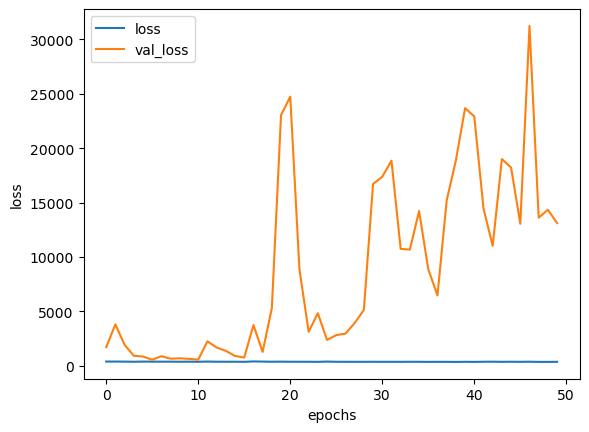

In [255]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [256]:
# 확인용도
model.predict(train_input[:5])

1/1 [==============================] - 0s 71ms/step


array([[146.25586],
       [147.01782],
       [147.77538],
       [147.92375],
       [146.73875]], dtype=float32)

In [257]:
# 여기랑 비슷한지 보기
train_target[:5]

,전국 관객수
952,20.175
335,56.282
933,21.071
1354,10.854
1007,18.501


### test data 확인용도

In [258]:
# 확인용도

# 오차율 몇 %로...?
pred = model.predict(독립_2023).round(0)
# 여기랑 비슷한지 보기
종속_2023 = 종속_2023.copy() ## 복사해서 사용
종속_2023['pred'] = pred
종속_2023['오차율'] = (abs(종속_2023['전국 관객수'] - 종속_2023['pred'])) / 종속_2023['전국 관객수'] * 100
len(종속_2023.loc[종속_2023['오차율']<20])

1/1 [==============================] - 0s 18ms/step


0

In [259]:
종속_2023

,전국 관객수,pred,오차율
56,92.369,149.0,61.309530
58,91.833,180.0,96.007971
68,90.281,175.0,93.839235
77,88.489,176.0,98.894778
358,54.192,160.0,195.246531
639,33.267,147.0,341.879340
646,32.590,155.0,375.606014
675,30.715,165.0,437.196809
803,25.387,153.0,502.670658
833,24.353,155.0,536.471893


In [26]:
tfjs.converters.save_keras_model(model,'saved_model')